# PCA Exercise

## Description

This notebooks contains two PCA-focused exercises and one tutorial. The first asks you to
explore a dataset of your choice, while the second walks through a synthetic
example that demonstrates how PCA can recover structure that has been hidden by
a higher-dimensional random rotation.

## Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

plt.style.use("seaborn-v0_8")

## Exercise 1: PCA plots

Apply PCA on a dataset of your choice and plot the following outputs:

- Scree plot (eigenvalues / explained variance)
- Eigenvectors (loadings)
- PairGrid (or scatter-matrix) over the first five principal components
- 3D plot of the first three principal components

Feel free to adapt the code from Exercise 2 as a template.

## Tutorial: Reverse Engineering

Steps for the synthetic example:

1. Create three well-separated Gaussian clusters in 3D (300×3 matrix).
2. Pad with zeros to build a (300×10) matrix whose last seven columns are zero.
3. Draw a random 10×10 rotation matrix from SO(10) and mix the padded data.
4. Apply PCA to recover the three informative dimensions.
5. Cluster the reduced representation with K-means to recover the bumps.

### Random rotation helper

Random SO(10) element generated.


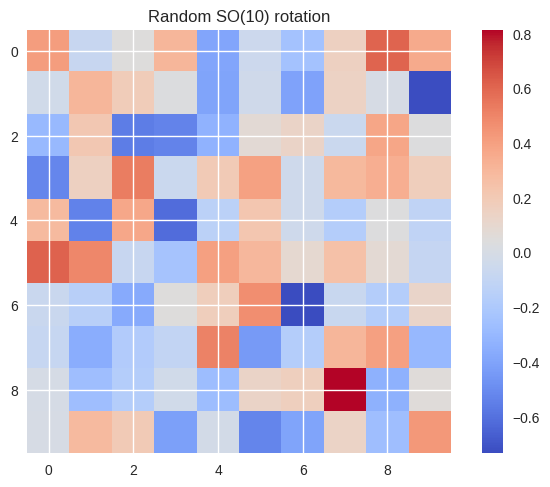

/storage/share/python/environments/Anaconda3/envs/neuropy-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 7488 (\N{MODIFIER LETTER CAPITAL T}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)


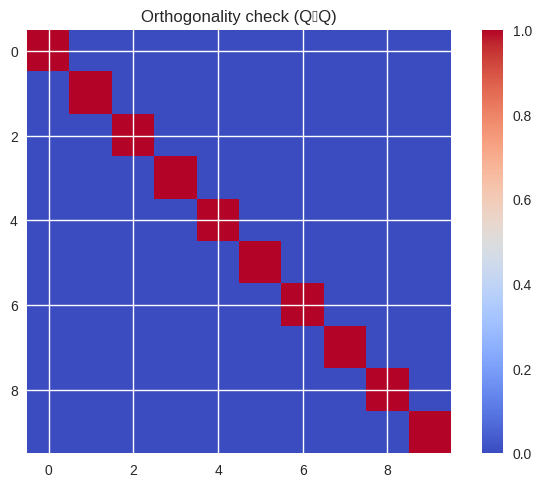

det(Q) = 0.9999999999999991


In [3]:
def random_son(n: int) -> np.ndarray:
    """Generate a random rotation (special orthogonal) matrix."""
    random_matrix = np.random.randn(n, n)
    q, r = np.linalg.qr(random_matrix)

    d = np.diag(r)
    phase = np.sign(d)
    phase[phase == 0] = 1  # avoid multiplying by zero
    q = q * phase

    if np.linalg.det(q) < 0:
        q[:, 0] *= -1

    return q


n = 10
rotation = random_son(n)
print("Random SO(10) element generated.")

plt.figure()
plt.imshow(rotation, cmap="coolwarm")
plt.title("Random SO(10) rotation")
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(rotation.T @ rotation, cmap="coolwarm")
plt.title("Orthogonality check (QᵀQ)")
plt.colorbar()
plt.show()

print("det(Q) =", np.linalg.det(rotation))

### Generate Gaussian clusters and embed

In [4]:
np.random.seed(0)

cluster1 = np.random.randn(100, 3) + np.array([0, 10, 0])
cluster2 = np.random.randn(100, 3) + np.array([10, 0, 0])
cluster3 = np.random.randn(100, 3) + np.array([0, 0, 10])

X = np.concatenate([cluster1, cluster2, cluster3])
print("X shape:", X.shape)

Z = np.concatenate([X, np.zeros((300, 7))], axis=1)
print("Z shape:", Z.shape)

X shape: (300, 3)
Z shape: (300, 10)


### Mix the data in 10D

S shape: (300, 10)


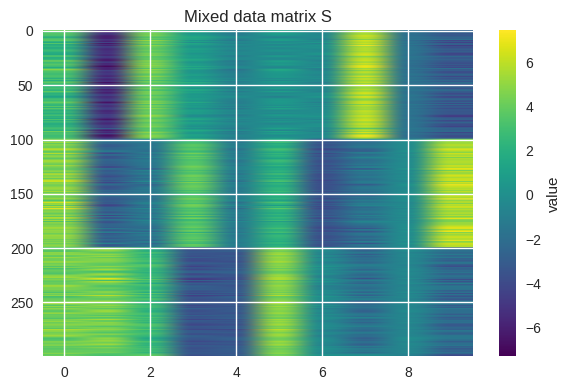

In [5]:
A = random_son(10)
S = Z @ A
print("S shape:", S.shape)

plt.figure(figsize=(6, 4))
plt.imshow(S, aspect="auto", cmap="viridis")
plt.title("Mixed data matrix S")
plt.colorbar(label="value")
plt.tight_layout()
plt.show()

### PCA analysis and diagnostics

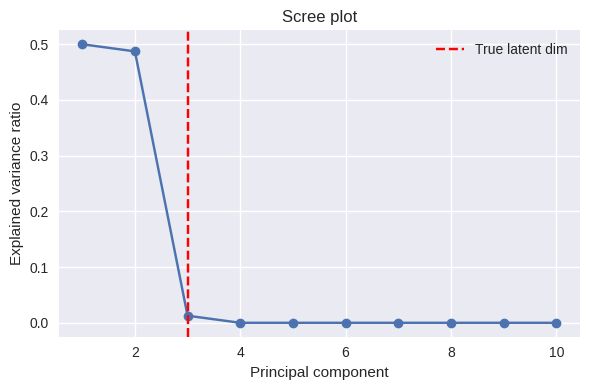

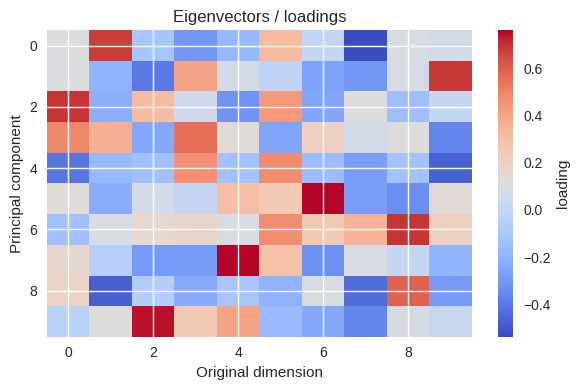

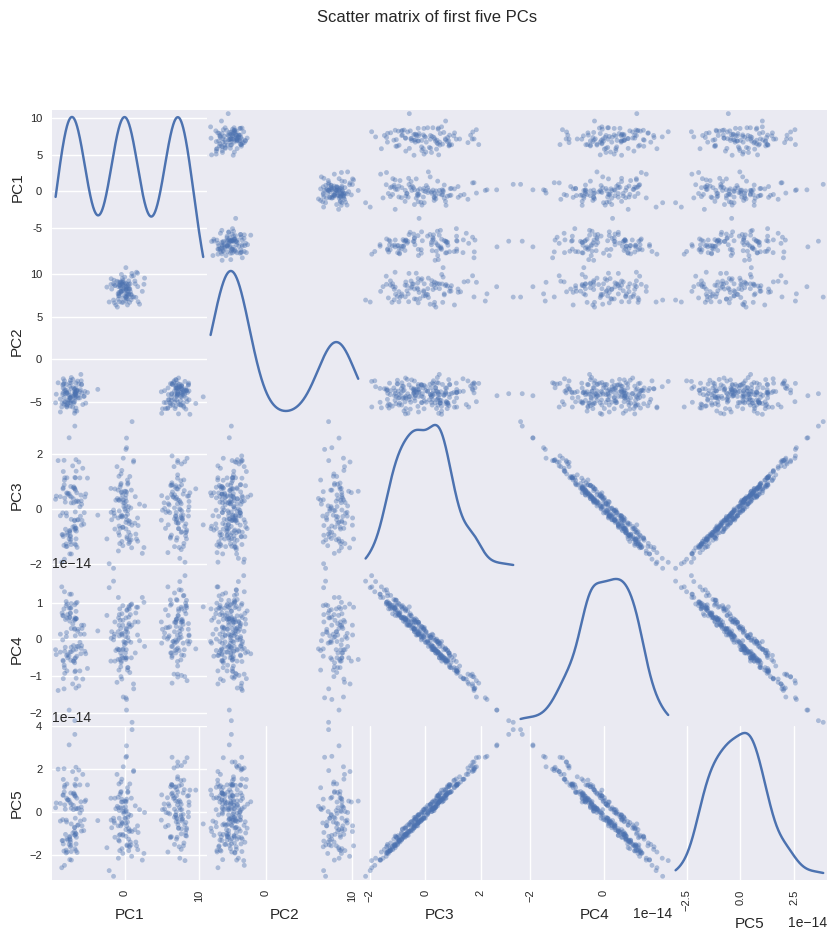

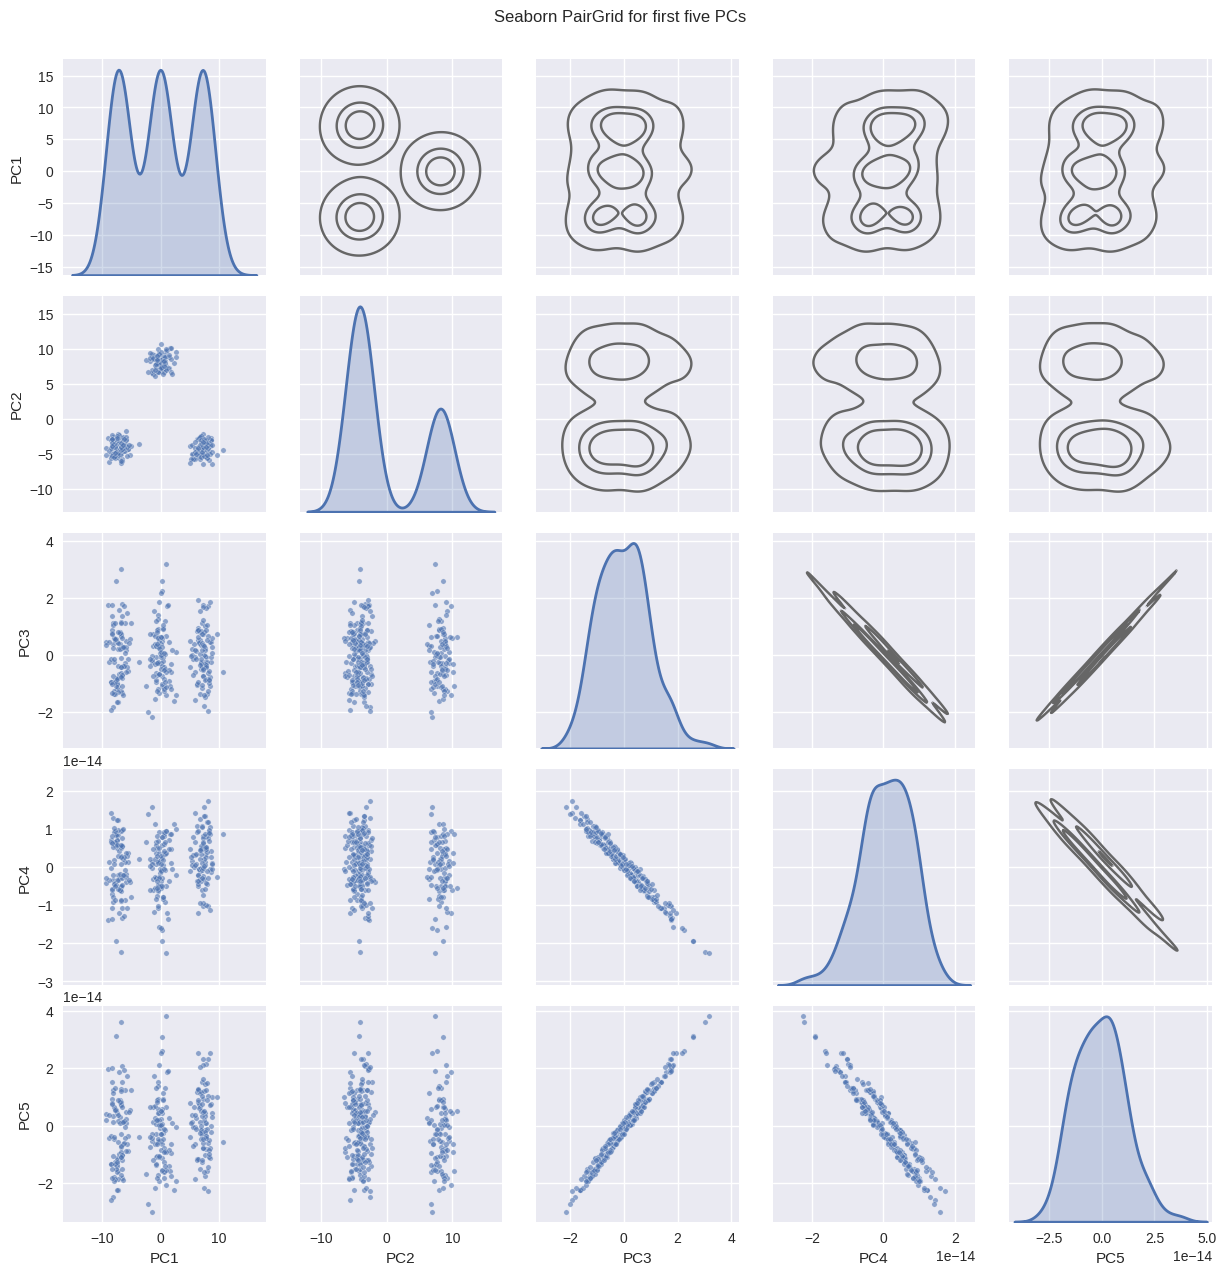

In [6]:
pca = PCA(n_components=10)
S_pca = pca.fit_transform(S)

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 11), pca.explained_variance_ratio_, marker="o")
plt.xlabel("Principal component")
plt.ylabel("Explained variance ratio")
plt.title("Scree plot")
plt.axvline(3, color="r", linestyle="--", label="True latent dim")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.imshow(pca.components_, aspect="auto", cmap="coolwarm")
plt.colorbar(label="loading")
plt.xlabel("Original dimension")
plt.ylabel("Principal component")
plt.title("Eigenvectors / loadings")
plt.tight_layout()
plt.show()

df = pd.DataFrame(S_pca, columns=[f"PC{i}" for i in range(1, 11)])

pd.plotting.scatter_matrix(
    df[[f"PC{i}" for i in range(1, 6)]],
    alpha=0.4,
    figsize=(10, 10),
    diagonal="kde",
)
plt.suptitle("Scatter matrix of first five PCs")
plt.show()

g = sns.PairGrid(df[["PC1", "PC2", "PC3", "PC4", "PC5"]], diag_sharey=False)
g.map_lower(sns.scatterplot, s=15, alpha=0.6)
g.map_diag(sns.kdeplot, lw=2, fill=True)
g.map_upper(sns.kdeplot, levels=4, color="0.4")
g.fig.suptitle("Seaborn PairGrid for first five PCs", y=1.02)
plt.show()

### Cluster in reduced space

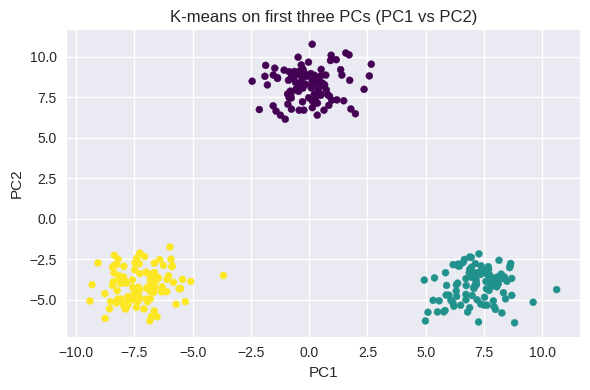

In [ ]:
S_pca_reduced = S_pca[:, :10]

kmeans = KMeans(n_clusters=3, n_init="auto", random_state=0)
kmeans.fit(S_pca_reduced)

plt.figure(figsize=(6, 4))
plt.scatter(
    S_pca_reduced[:, 0],
    S_pca_reduced[:, 1],
    c=kmeans.labels_,
    cmap="viridis",
    s=25,
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-means on first three PCs (PC1 vs PC2)")
plt.tight_layout()
plt.show()

## Exercise 2 - Reverse Engineering

- Repeat the tutorial pipeline with nongaussian clusters (e.g., moons, circles). Can PCA still recover the structure?

Steps for the synthetic example:

1. Create three well-separated Nongaussian clusters in 3D (300×3 matrix).
2. Pad with zeros to build a (300×10) matrix whose last seven columns are zero.
3. Draw a random 10×10 rotation matrix from SO(10) and mix the padded data.
4. Apply PCA to recover the three informative dimensions.
5. Cluster the reduced representation with K-means to recover the bumps.

Good luck!